In [573]:
import camelot as c
from camelot import utils
import os
import pandas as pd
import matplotlib.pyplot as plt

files = os.listdir(r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple")
pre = r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\\"

In [574]:
# for file in files:
#     pdf = pre + file
#     tables = c.read_pdf(pdf, "all")
#     for table in tables:
#         if table.parsing_report["accuracy"] > 0.90:
#             dir = f"./data/{file}"
#             if not os.path.exists(dir):
#                 os.mkdir(dir)
#             table.to_csv(dir + f"/{table.parsing_report['order']}.csv")

# Single-File

In [575]:
# pdf = "Farhi_Y_2018_Coins_from_the_2008_2009_Ex"
# testPDF = pre + pdf + ".pdf" # 100,600,500,100 ||| 476,200,788,631 ||| tlx tly brx bry ||| (0,0) in BL corner
# tables = c.read_pdf(testPDF, "7", flavor="lattice", line_scale=40, line_tol=8, table_areas=["100,600,500,100"]) # line tolerance issues, must be variable. if too big, wont run

### Remove Duplicate Headers

In [576]:
# overall_df = tables[0].df
# for table in tables[1:]:
#     cur_df = table.df

#     if cur_df[0][0] == overall_df[0][0]: # if non-initial table includes header again...
#         cur_df = cur_df.drop(0) # ...remove the header

#     overall_df = overall_df.merge(cur_df, how="outer")

In [577]:
# cur_group = ""
# new_col = []
# group_indices = []

# for index, row in overall_df.iterrows():
#     if sum(value != "" for value in row) == 1: # if only one cell filled --- indicates this is a grouping label/separator
#         cur_group = next(value for value in row if value != "")
#         group_indices.append(index)
#     else:
#         new_col.append(cur_group)

# for index in group_indices:
#     overall_df = overall_df.drop(index)

# overall_df = overall_df.assign(group=new_col) # append new groups column

In [578]:
# overall_df.to_csv("CUR.csv", index=False, header=False, encoding="utf-8") # need to add label for group depending on user input

In [579]:
# print(table.parsing_report)
# pdf = "Farhi_Y_2018_Coins_from_the_2008_2009_Ex"
# testPDF = pre + pdf + ".pdf" # 100,600,500,100 ||| 476,200,788,631 ||| LX HiY RX LowY ||| (0,0) in BL corner ||| swap 2-4
# tables = c.read_pdf(testPDF, "7", flavor="lattice", line_scale=40, line_tol=8, table_areas=["0,755,577,100"]) # line tolerance issues, must be variable. if too big, wont run
# table = tables[0]
# c.plot(table, kind="contour") # line joint, text grid contour, textedge (Lat, Both, Stream)

# Bounding box tool

In [580]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
import pymupdf as mu
from screeninfo import get_monitors
import ctypes

In [581]:
tlx, tly, brx, bry = -1, -1, -1, -1

def draw(event, canvas):
    global tlx, bry
    tlx = event.x
    bry = event.y
    canvas.create_oval(tlx-2, bry-2, tlx+2, bry+2, fill="Black")

def end_draw(event, transparent, canvas, capture_button, confirm_button):
    global brx, tly
    brx = event.x
    tly = event.y
    canvas.create_rectangle(tlx, tly, brx, bry, outline="black", width=5)
    capture_button.config(text="Redraw?")
    transparent.after(1000, transparent.destroy)
    confirm_button.pack()
    
def on_capture_button_click(tool):
    transparent = tk.Tk()
    transparent.overrideredirect(True)
    transparent.state('zoomed')
    canvas = tk.Canvas(transparent)
    canvas.pack(fill=tk.BOTH, expand=True)

    capture_button = tool.children.get("capture_button")
    capture_button.config(text="...")

    confirm_button = tool.children.get("confirm_button")

    transparent.attributes("-alpha", 0.5)

    canvas.bind("<ButtonPress-1>", lambda event: draw(event, canvas))
    canvas.bind("<ButtonRelease-1>", lambda event: end_draw(event, transparent, canvas, capture_button, confirm_button))

In [582]:
def get_pdf_page_dimensions(pdf_path, page_number):

    document = mu.open(pdf_path)
    page = document.load_page(page_number-1)

    rect = page.rect
    width = rect.width
    height = rect.height

    return width, height

In [583]:
file = ""

def browser_to_pdf_coord(tlx, tly, brx, bry, tool):

    pdf_width, pdf_height = get_pdf_page_dimensions(file, 1)
    # print(f"{pdf_width}, {pdf_height}")

    dpi = round(tool.winfo_fpixels("1i")) # 96 for me, seems to be standard unless you're running this on a smart fridge
    factor = 72 / dpi 

    # converting to PDF dpi (72)
    tlx *= factor
    tly *= factor
    brx *= factor
    bry *= factor

    # print(f"X-Distance: {brx-tlx}")

    monitor = get_monitors()[0]
    width_res = monitor.width * factor
    height_res = monitor.height * factor

    window_junk_above_pdf_reader = 152 * factor
    height_res -= window_junk_above_pdf_reader

    scale = height_res / pdf_height    

    # print(f"tlx before 87% scale: {tlx}")

    tlx /= scale
    brx /= scale

    # print(f"tlx after 87% scale: {tlx}")

    pdf_width *= scale
    # print(f"PDF_WIDTH IS {pdf_width}")

    pdf_left = (width_res - pdf_width) / 2 # equivalently: (width_res / 2) - (pdf_width / 2)
    pdf_bottom = 146 * factor # 

    # print(f"tlx is {tlx} ||| pdf_left is {pdf_left}")

    scrollBar = 7 # mathematically supposed to be 12.75

    pdf_left /= scale # experimental
    pdf_left -= scrollBar # only if more than 1 page

    # print(f"tlx before subtracting pdf_left: {tlx}")

    tlx -= pdf_left
    brx -= pdf_left

    # print(f"tlx after subtracting pdf_left: {tlx}")

    # print(f"SCALE IS {scale}-------------------------------------------------")

    tly -= pdf_bottom
    bry -= pdf_bottom

    # print(f"Left: {pdf_left}")
    # print(f"Bottom: {pdf_bottom}")

    return [f"{tlx},{tly},{brx},{bry}"]

In [584]:
def extract(tool): # upon pressing "confirm" after boxing the table
    area = browser_to_pdf_coord(tlx, tly, brx, bry, tool)
    print(area)
    tables = c.read_pdf(f"{file}", "1", flavor="lattice", line_scale=40, line_tol=8, table_areas=area)
    print(len(tables))
    c.plot(tables[0], kind="contour") # line joint, text grid contour, textedge (Lat, Both, Stream)
    plt.show()
    

def upload_file(capture_button):
    file_path = filedialog.askopenfilename(filetypes=[("PDF files", "*.pdf"), ("All files", "*.*")])
    if file_path:
        # print(file_path)
        global file
        file = file_path
        capture_button.pack()
        

['66.00431034482756,301.5,434.8405172413793,81.0']
1


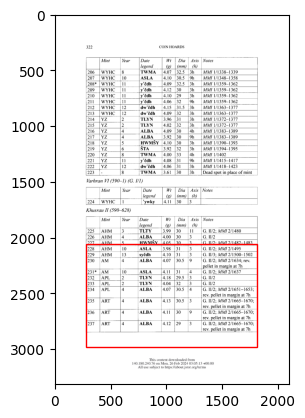

In [585]:
tool = tk.Tk()
tool.title("COINS")
label = tk.Label(tool, text="COINS")
label.pack()

capture_button = tk.Button(tool, text="Capture table", name="capture_button", 
                           command=lambda: on_capture_button_click(tool))

confirm_button = tk.Button(tool, text="Confirm", name="confirm_button", command=lambda: extract(tool))

upload_button = tk.Button(tool, text="Upload PDF", name='upload_button', command=lambda: upload_file(capture_button))
upload_button.pack()

tool.mainloop()

### Notes 

Ariel & Berman: Perfect, 98.76, 47.55
Farhi_Y_2018_Coins_from_the_2008_2009_Ex: Horrible, 100, 22.73



Iran2 = 1.631
actual: 504.0, 796.0
guessed x1=135.7 x2=444.7 = 309

Ariel = 1.6300625
actual: 524.4089965820312, 765.35400390625
guessed: x1=129.7 x2=451.3 = 321.6

Farhi = 1.6342069
actual: 592.4, 779.5
guessed: x1=109 x2=471.5 = 362.5

My dpi: 96
Their dpi: 72

309 at 96dpi --> 504 at 72dpi

309 at 48 dpi makes better sense; 
309/48=~6.5 which is the correct length. 
So 309 at 48 dpi 

# Above was when at 150% zoom, below is 100%

starts at 460 in pdf dpi (72); 

# Time: 11-

Nice